<a href="https://colab.research.google.com/github/AmadeuAnjos/IniciacaoCientifica-Lung/blob/main/COVID_19_Lung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
tf.__version__

'2.4.1'

# Carregamento da base de dados


Abaixo fazemos a conexão com o Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Abaixo descompactamos o arquivo puxado do Google Drive, extraimos e fechamos o zipfile.

In [ ]:
path = "/content/drive/My Drive/covid_dataset.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

Abaixo carregamos duas imagens, uma de um pulmão com covid-19 e outra um pouco mais abaixo um pulmão saudável. utilizamos o tamanho de imagem 224x224.

In [ ]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png', target_size=(224,224))

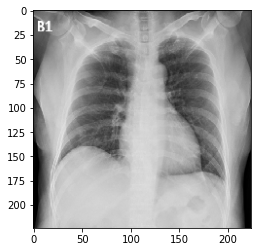

In [ ]:
plt.imshow(image);

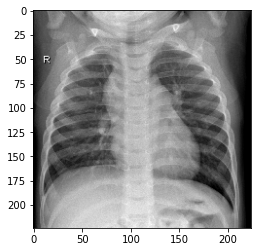

In [ ]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/normal/NORMAL2-IM-1294-0001-0001.jpeg', target_size=(224, 224))
plt.imshow(image);

# Criando a base de dados treino

Abaixo transformamos as imagens para o formato do TensorFlow.

Usamos o ImageDataGenerator para gerar imagens a partir das imagens que temos no dataset, rotacionamos para esquerda, para a direita, damos zoom, diminuimos para que tenhamos mais imagens.

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

Abaixo buscamos as imagens do diretório para treinamento e passamos os parâmetros de tamanho de imagem que será utilizados '224x224', passamos o 'batch_size=16' que será o tamanho do grupo de imagens que será utilizados para treinamento, usamos o parâmetro 'categorical' que é para classificar as imagens e 'shuffle = True' que é para pegar imagens aleatórias.

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/covid_dataset/train',
                                                    target_size = (224, 224),
                                                    batch_size=16,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 101 images belonging to 2 classes.


Abaixo é retornado a quantidade de imagens encontradas.

In [ ]:
train_generator.n

101

Abaixo é retornado o tamanho do grupo de imagens.

In [ ]:
train_generator.batch_size

16

Abaixo é dividido a quantidade de imagens encontradas pelo grupo de imagens que foram treinadas.

In [ ]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_train

6

# Criando a base de dados teste

Abaixo usamos novamente o ImageDataGenerator, mas diferente do treino, pois usamos imagens originais para teste.

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

Abaixo buscamos as imagens para teste do diretório com os parâmetros; tamanho da imagem, tamanho do grupo que será treinado, modo categorical que classifica as imagens e o shuffle para testar imagens aleatórias.

In [ ]:
test_generator = test_datagen.flow_from_directory('/content/covid_dataset/test',
                                                  target_size=(224,244),
                                                  batch_size=16,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 22 images belonging to 2 classes.


Abaixo é dividido a quantidade de imagens encontradas pelo grupo de imagens que foram testadas.

In [ ]:
step_size_test = test_generator.n // test_generator.batch_size
step_size_test

1

## Construção do modelo a partir da técnica Transfer Learning

Abaixo carregamos a arquitetura ResNet50, passamos o 'weights='imagenet' que é uma base de dados já treinada, assim elimina uma construção do zero. Passamos o parâmetro 'include_top=False' que elimina a classificação das imagens e carrega apenas a parte convolucional.

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


Abaixo com o parâmetro 'sumary' é carregado todas as camadas da rede neural.

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Abaixo carregamos a última camada da rede neural

In [ ]:
x = base_model.output

Abaixo aplicamos 'GlobalAveragePooling2D()' reduzindo a dimensionalidade dos dados e tirando a média da variável 'x' que recebe a última camada convulocional.

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

Abaixo carregamos uma série de camadas densas.....

In [ ]:
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = base_model.input, outputs = preds)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
for layer in model.layers[:175]:
  layer.trainable = False  

In [ ]:
for layer in model.layers[175:]:
  layer.trainable = True  

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=20,
                              steps_per_epoch=step_size_train,
                              validation_data = test_generator,
                              validation_steps=step_size_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
6/6 [==============================] - 39s 830ms/step - loss: 4.1788 - accuracy: 0.5132 - val_loss: 0.4382 - val_accuracy: 0.9545
Epoch 2/20
6/6 [==============================] - 3s 578ms/step - loss: 0.7607 - accuracy: 0.7352 - val_loss: 0.1678 - val_accuracy: 0.9545
Epoch 3/20
6/6 [==============================] - 3s 568ms/step - loss: 0.3446 - accuracy: 0.8394 - val_loss: 0.2018 - val_accuracy: 0.9545
Epoch 4/20
6/6 [==============================] - 3s 572ms/step - loss: 0.2601 - accuracy: 0.9022 - val_loss: 0.1079 - val_accuracy: 0.9545
Epoch 5/20
6/6 [==============================] - 3s 637ms/step - loss: 0.0673 - accuracy: 0.9731 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 3s 637ms/step - loss: 0.0715 - accuracy: 0.9526 - val_loss: 0.0696 - val_accuracy: 0.9545
Epoch 7/20
6/6 [==============================] - 3s 630ms/step - loss: 0.0669 - accuracy: 0.9812 - val_loss: 2.2432e-04 - val_accuracy: 1.0000
Epoch 8/20
6/6 

# Avaliação

## Gráficos

In [ ]:
np.mean(history.history['val_accuracy'])

0.9795454472303391

In [ ]:
np.std(history.history['val_accuracy'])

0.02261335893049674

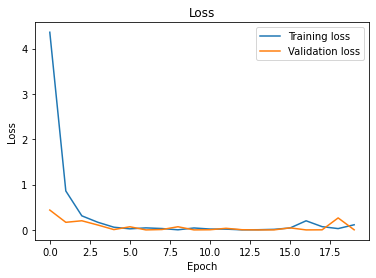

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

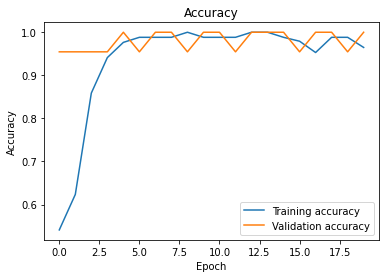

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

## Previsões

In [ ]:
filenames = test_generator.filenames
filenames

['covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg',
 'covid/1-s2.0-S0140673620303706-fx1_lrg.jpg',
 'covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
 'covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg',
 'covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg',
 'covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',
 'covid/1-s2.0-S1684118220300608-main.pdf-001.jpg',
 'covid/1-s2.0-S1684118220300608-main.pdf-002.jpg',
 'covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png',
 'covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png',
 'covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg',
 'normal/NORMAL2-IM-1281-0001.jpeg',
 'normal/NORMAL2-IM-1282-0001.jpeg',
 'normal/NORMAL2-IM-1285-0001.jpeg',
 'normal/NORMAL2-IM-1286-0001.jpeg',
 'normal/NORMAL2-IM-1288-0001.jpeg',
 'normal/NORMAL2-IM-1289-0001.jpeg',
 'normal/NORMAL2-IM-1290-0001.jpeg',
 'normal/NORMAL2-IM-1291-0001.jpeg',
 'normal/NORMAL2-IM-1292-0001.jpeg',
 'normal/NORMAL2-IM-1293-0001.jpeg',
 'normal/NORMAL2-IM-1294-0001.jpeg']

In [ ]:
len(filenames)

22

In [ ]:
predictions = model.predict_generator(test_generator, steps = len(filenames))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
predictions

array([[1.0000000e+00, 8.4983238e-09],
       [1.0000000e+00, 1.0830740e-08],
       [1.0000000e+00, 2.2565310e-09],
       [1.0000000e+00, 1.1474242e-08],
       [1.0000000e+00, 3.8296196e-08],
       [1.0000000e+00, 3.0028030e-08],
       [1.0000000e+00, 2.2691305e-08],
       [9.9999881e-01, 1.2477984e-06],
       [1.0000000e+00, 9.4471664e-10],
       [9.9985671e-01, 1.4329868e-04],
       [1.0000000e+00, 2.0816149e-09],
       [2.0455276e-03, 9.9795449e-01],
       [1.2553248e-04, 9.9987447e-01],
       [6.4302068e-05, 9.9993575e-01],
       [8.1796544e-03, 9.9182034e-01],
       [6.5262709e-04, 9.9934739e-01],
       [1.5784138e-03, 9.9842155e-01],
       [1.8616113e-03, 9.9813843e-01],
       [3.6054574e-02, 9.6394545e-01],
       [1.8314359e-04, 9.9981683e-01],
       [1.4395041e-03, 9.9856049e-01],
       [3.0350694e-03, 9.9696487e-01]], dtype=float32)

In [ ]:
len(predictions)

22

In [ ]:
predictions2 = []
for i in range(len(predictions)):
  #print(predictions[i])
  predictions2.append(np.argmax(predictions[i]))

In [ ]:
predictions2

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
test_generator.class_indices

{'covid': 0, 'normal': 1}

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(predictions2, test_generator.classes)

1.0

In [ ]:
cm = confusion_matrix(predictions2, test_generator.classes)
cm

array([[11,  0],
       [ 0, 11]])

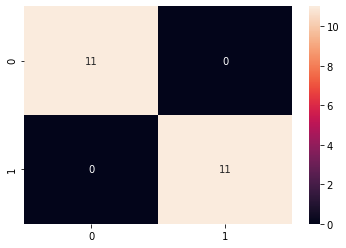

In [ ]:
sns.heatmap(cm, annot=True);

## Teste com imagem

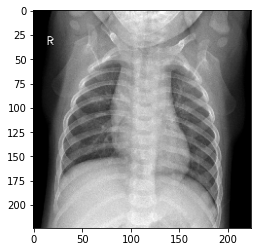

In [ ]:
image = tf.keras.preprocessing.image.load_img(r'/content/covid_dataset/normal/NORMAL2-IM-1307-0001.jpeg', target_size=(224,224))
plt.imshow(image);

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
image = tf.keras.preprocessing.image.img_to_array(image)
np.shape(image)

(224, 224, 3)

In [ ]:
type(image)

numpy.ndarray

In [ ]:
np.max(image), np.min(image)

(255.0, 0.0)

In [ ]:
image = np.expand_dims(image, axis = 0)
np.shape(image)

(1, 224, 224, 3)

In [ ]:
image = tf.keras.applications.resnet50.preprocess_input(image)

In [ ]:
np.max(image), np.min(image)

(151.061, -123.68)

In [ ]:
predictions = model.predict(image)
print(predictions)

[[0.00280254 0.9971975 ]]


In [ ]:
predictions[0]

array([0.00280254, 0.9971975 ], dtype=float32)

In [ ]:
np.argmax(predictions[0])

1

In [ ]:
list(train_generator.class_indices)

['covid', 'normal']

In [ ]:
prediction = list(train_generator.class_indices)[np.argmax(predictions[0])]
prediction

'normal'